5/28/2024
1. Updated to calculate v but graph u
2. Explicit method still displaying blow up in short time, but this time to the left of shock
3. Function doesn't match book but closer; right wave front seems upside down.
4. Continue to work on building implicit (tridiagonal) solution for CR.

# Nonlinear Klein-Gordon (General): $u_{tt} - u_{rr} + m^{2}u + G'(u) = 0$
#### where $G'(u) = |u|^{p-1}u$, 
#### substituting $v = ur$ and $m=1$:
## $v_{tt} - v_{rr} + v + r^{1-p}|v|^{p-1}v = 0$

## 1. Explicit Method

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

%matplotlib widget
from IPython.display import display, clear_output
from mpl_toolkits.mplot3d import Axes3D

import heat_equations as PDE

#### INITIAL & BOUNDARY CONDITIONS:

In [2]:
# ! - Initial Condition Function.  
def f_u_0_x(r):
    '''
    Loop through the initial grid nodes and apply the function at each point.  If the result is above or below
    a certain threshold, set the output to zero.
    
    Returns: r =  [array].
    '''
    for i in range(len(r)):
        x_0 = 5*np.e**(100*(1-(1-(10*r[i]-1)**2)**-1))
        if x_0 > 5:
            r[i] = 0
        elif x_0 < .000004:
            r[i] = 0
        else:
            r[i] = x_0
    return r

# Boundary Condition Functions (Dirchelet)
def f_u_t_0(t):
    '''
    Assigns the initial value for the 0-boundary.
    If the boundary is a constant value, leave function as-is.
    If boundary is a function of t, replace return value with function.
    
    Parameters: t = time [Float]    
    '''    
    return 0

def f_u_t_L(t):
    '''
    Assigns the initial value for the L-boundary.
    If the boundary is a constant value, leave function as-is.
    If boundary is a function of t, replace return value with function.
    
    Parameters: t = time [Float] 
    '''
    return 0

In [3]:
def nonlinear_kg_timestep(u_line,u_line_previous,m,dt,dx,p):
    '''
    Takes in:
    -u_line: a 1D array
    -u_line_previous: a 1D array
    -m: a space index 
    -dt: time step
    -dx: x step
    -p: the exponent used for G'(u)
    
    ***Add notes here about derivation from the centered difference from each side of the equation***
    
    Returns:
    -u, an array containing solutions for that timestep
    
    '''
    r = m * dx
    return ((dt**2/dx**2) * (u_line[m+1] + u_line[m-1] - 2*u_line[m]) - 
            (dt**2 * r**(1-p) * abs(u_line[m])**(p-1) * u_line[m]) - 
            (dt**2 * u_line[m]) + 2*u_line[m] - u_line_previous[m])

#### COMPLETE CODE:

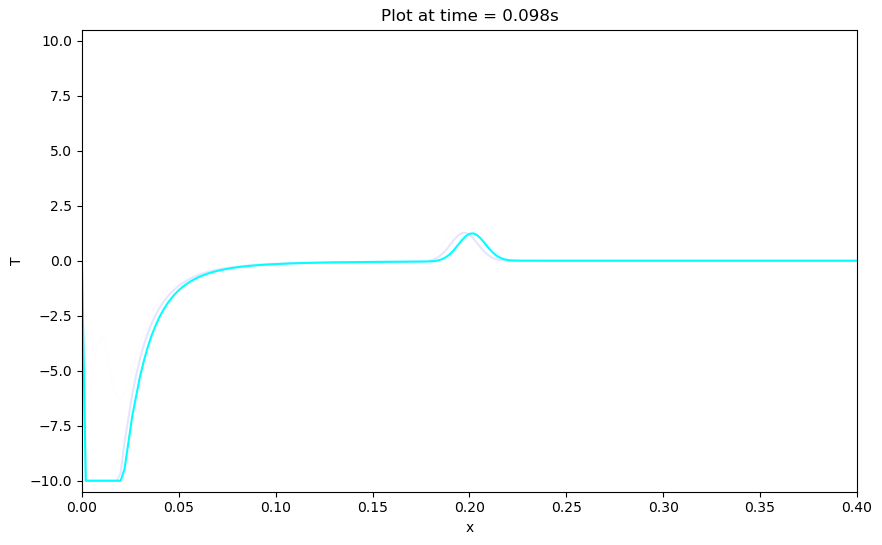

In [4]:
# -- User Defined - IC and Boundary condition functions determined at start of notebook
L = .4
t_max = .2

p = 5

# m = 1

dx = .002 # dx = dr
dt = .002

steps = 20
t_min_plot = 0           # default = 0
t_max_plot = t_max/2     # default = t_max
x_min_plot = 0           # default = 0
x_max_plot = L           # default = L


# Do not change below line
# ===================================
# -- Create a stability check
if dx/dt < 1:
    raise Exception(f"Entered dt is outside of stability range.  Please enter a smaller step size.")

# -- Calculated
Nx = int(L/dx) 
Nt = int(t_max/dt)

x_grid = np.linspace(0,L,Nx+1)
t_grid = np.linspace(0,t_max,Nt+1)

# Since initial conditions are for u, need to start with u then convert to v
u = []

# -- Append initial conditions (t = 0) and boundary conditions (x = 0, x = L)
u_t_x_0 = f_u_0_x(x_grid)

u_t_x_0[0] = f_u_t_0(0)
u_t_x_0[-1] = f_u_t_L(0)

# -- Below is done to get data types correct, it was the easy fix
u_t_x_0 = list(u_t_x_0)

u.append(u_t_x_0)

# Create the v (for calculations purposes)
v = []
v_t_x_0 = u_t_x_0.copy()
for i in range(len(u_t_x_0)):
    v_t_x_0[i] = u_t_x_0[i]*(i*dx)
v.append(v_t_x_0)

v_previous = v[-1]

for j in range(len(t_grid)):
    v_t_x = []
    
    # Quick fix for v to u
    u_t_x = []
    
    v_line = v[-1]
    
    for m in range(1,len(x_grid)-1):
        vm = nonlinear_kg_timestep(v_line,v_previous,m,dt,dx,p)
        
        v_t_x.append(vm)
        
        # For v to u: cut off blow up values
        um = vm/(m*dx)
        if um < -10:
            um = -10
        elif um > 10:
            um = 10
        u_t_x.append(um)
   
    v_previous = v_line

    # Append the first and last value with boundary conditions (0 in this case)
    v_t_x.insert(0,f_u_t_0(0))
    v_t_x.append(f_u_t_L(0))
    
    # Need to append u as well
    u_t_x.insert(0,f_u_t_0(0))
    u_t_x.append(f_u_t_L(0))

    # Now append the full calculation matrix
    v.append(v_t_x)
    
    # Append full solutions matrix
    u.append(u_t_x)
    
PDE.PDE_plotter_1D(u, L, t_max, steps, t_min_plot, t_max_plot, x_min_plot, x_max_plot, alpha_decay = .1)

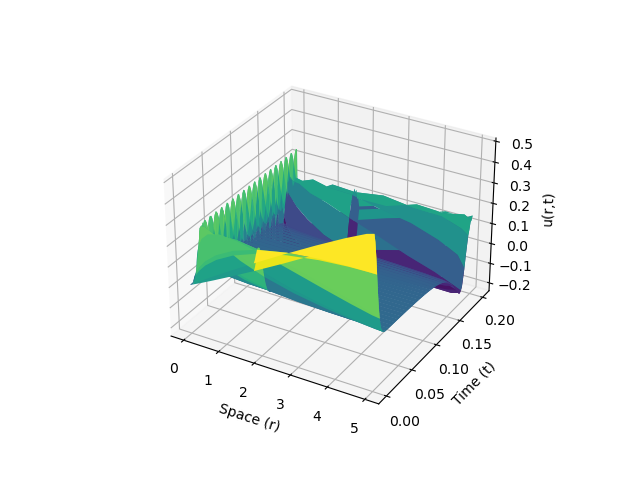

In [5]:
R, T = np.meshgrid(x_grid, t_grid)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(R, T, np.array(v[:-1]), cmap='viridis')
ax.set_xlabel('Space (r)')
ax.set_ylabel('Time (t)')
ax.set_zlabel('u(r,t)')
plt.show()

## 2. Other Methods to Solve
Using a modified Crank-Nicholson: Needs work!

In [6]:
# Parameters
L = 1  # length of the spatial domain
T = 1   # total time
m = 1.0   # mass term
N_r = 100  # number of spatial steps
N_t = 100  # number of time steps
delta_r = L / N_r
delta_t = T / N_t

p = 3

# Discretized space and time
r = np.linspace(0, L, N_r+1)
t = np.linspace(0, T, N_t+1)

# Initial conditions
u = np.zeros((N_t+1, N_r+1))
u[0, :] = f_u_0_x(r)  # initial condition at t=0

# Placeholder for G'(u)
def G_prime(u):
    return abs(u)**(p-1)*u  # example nonlinear term

# Time-stepping loop
for n in range(1, N_t):
    # Coefficient matrix and RHS vector
    A = diags([1, -2, 1], [-1, 0, 1], shape=(N_r+1, N_r+1)).toarray()
    A = (np.identity(N_r+1) - delta_t**2 / (2 * delta_r**2) * A)
    b = u[n-1, :] + delta_t**2 / 2 * (m**2 * u[n, :] + G_prime(u[n, :]))
    
    # Solve for u^{n+1}
    u[n+1, :] = spsolve(A, b)

/var/folders/nw/8yyyyp8n70vbplhdsylyqs8c0000gn/T/ipykernel_82620/1420587724.py:10: RuntimeWarning: divide by zero encountered in scalar power
  x_0 = 5*np.e**(100*(1-(1-(10*r[i]-1)**2)**-1))
/opt/homebrew/anaconda3/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:229: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


In [8]:
steps = 10
t_min_plot = .25            # default = 0
t_max_plot = len(U_7)         # default = len(U_7)
x_min_plot = 0            # default = 0
x_max_plot = L           # default = t_max
PDE.PDE_plotter_1D(u, L, t_max, steps, t_min_plot, t_max_plot, x_min_plot, x_max_plot, alpha_decay = .8)

NameError: name 'U_7' is not defined

In [ ]:
R, T = np.meshgrid(r, t)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(R, T, u, cmap='viridis')
ax.set_xlabel('Space (r)')
ax.set_ylabel('Time (t)')
ax.set_zlabel('u(r,t)')
plt.show()

In [4]:
# -- User Defined - IC and Boundary condition functions determined at start of notebook
L = .4
t_max = .2

p = 5

# m = 1

dx = .002 # dx = dr
dt = .002

# -- Create a stability check
if dx/dt < 1:
    raise Exception(f"Entered dt is outside of stability range.  Please enter a smaller step size.")

# -- Calculated
Nx = int(L/dx) 
Nt = int(t_max/dt)

x_grid = np.linspace(0,L,Nx+1)
t_grid = np.linspace(0,t_max,Nt+1)

# Since initial conditions are for u, need to start with u then convert to v
u = []

# -- Append initial conditions (t = 0) and boundary conditions (x = 0, x = L)
u_t_x_0 = f_u_0_x(x_grid)

u_t_x_0[0] = f_u_t_0(0)
u_t_x_0[-1] = f_u_t_L(0)

# -- Below is done to get data types correct, it was the easy fix
u_t_x_0 = list(u_t_x_0)

u.append(u_t_x_0)

/var/folders/nw/8yyyyp8n70vbplhdsylyqs8c0000gn/T/ipykernel_31160/3767740299.py:4: RuntimeWarning: divide by zero encountered in scalar power
  x_0 = 5*np.e**(100*(1-(1-(10*r[i]-1)**2)**-1))
/var/folders/nw/8yyyyp8n70vbplhdsylyqs8c0000gn/T/ipykernel_31160/3767740299.py:4: RuntimeWarning: overflow encountered in scalar power
  x_0 = 5*np.e**(100*(1-(1-(10*r[i]-1)**2)**-1))


In [5]:
# Create the v (for calculations purposes)
v = []
v_t_x_0 = u_t_x_0.copy()
for i in range(len(u_t_x_0)):
    v_t_x_0[i] = u_t_x_0[i]*(i*dx)
v.append(v_t_x_0)

v_previous = v[-1]

In [6]:
for j in range(len(t_grid)):
    v_t_x = []
    
    # Quick fix for v to u
    u_t_x = []
    
    v_line = v[-1]
    
    for m in range(1,len(x_grid)-1):
        vm = nonlinear_kg_timestep(v_line,v_previous,m,dt,dx,p)
        
        v_t_x.append(vm)
        
        # For v to u: cut off blow up values
        um = vm/(m*dx)
        if um < -10:
            um = -10
        elif um > 10:
            um = 10
        u_t_x.append(um)
   
    v_previous = v_line

    # Append the first and last value with boundary conditions (0 in this case)
    v_t_x.insert(0,f_u_t_0(0))
    v_t_x.append(f_u_t_L(0))
    
    # Need to append u as well
    u_t_x.insert(0,f_u_t_0(0))
    u_t_x.append(f_u_t_L(0))

    # Now append the full calculation matrix
    v.append(v_t_x)
    
    # Append full solutions matrix
    u.append(u_t_x)

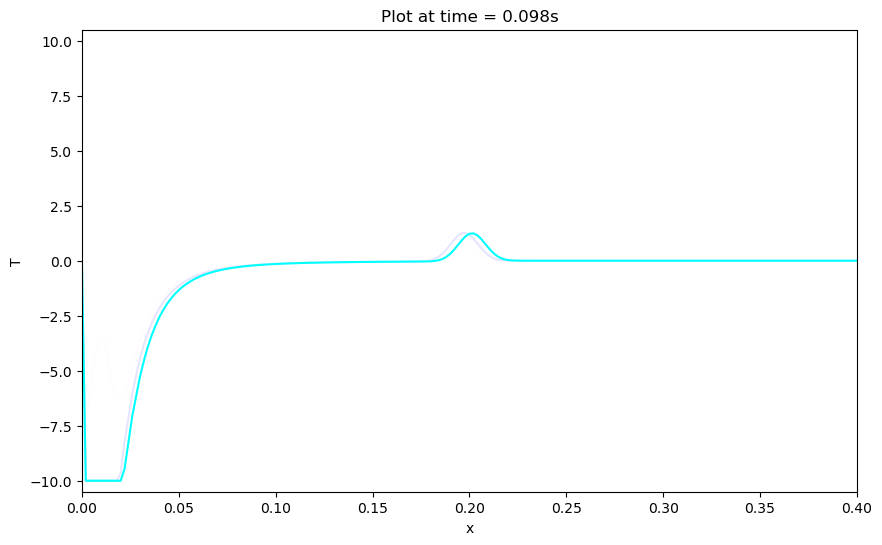

In [11]:
steps = 20
t_min_plot = 0            # default = 0
t_max_plot = t_max/2          # default = len(U_7)
x_min_plot = 0           # default = 0
x_max_plot = L           # default = t_max
PDE.PDE_plotter_1D(u, L, t_max, steps, t_min_plot, t_max_plot, x_min_plot, x_max_plot, alpha_decay = .1)

In [17]:
def nonlinear_kg_simple(u_line,u_line_previous,m,dt,dx,p):
    r = m * dx
    return dt**2/dx**2 * (u_line[m+1] + u_line[m-1] - 2*u_line[m])  +  dt**2/(r*dx) * (u_line[m+1] - u_line[m-1])  -  dt**2 * u_line[m]  +  2 * u_line[m]  -  u_line_previous[m]  -  dt**2 * abs(u_line[m])**(p-1) * u_line[m]

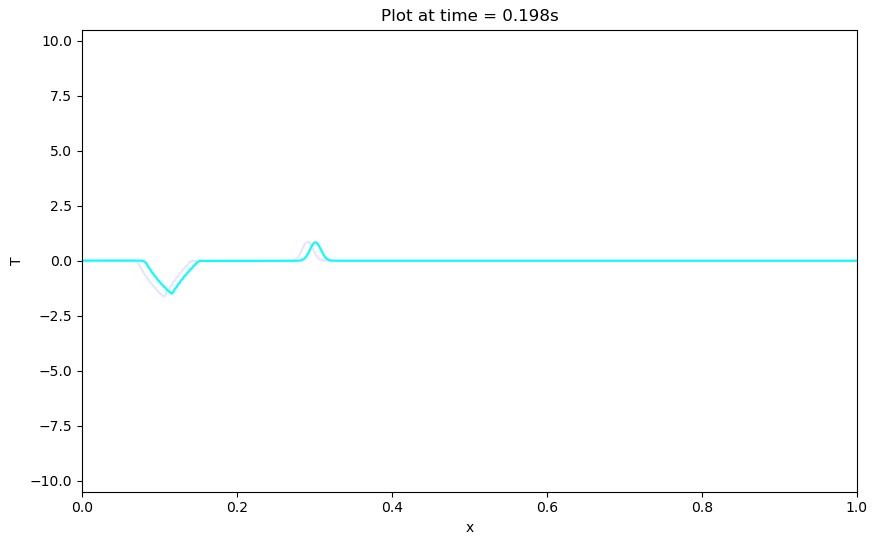

In [25]:
# -- User Defined - IC and Boundary condition functions determined at start of notebook
L = 1
t_max = .4

p = 2

# m = 1

dx = .002 # dx = dr
dt = .002

steps = 20
t_min_plot = 0           # default = 0
t_max_plot = t_max/2     # default = t_max
x_min_plot = 0           # default = 0
x_max_plot = L           # default = L


# Do not change below line
# ===================================
# -- Create a stability check
if dx/dt < 1:
    raise Exception(f"Entered dt is outside of stability range.  Please enter a smaller step size.")

# -- Calculated
Nx = int(L/dx) 
Nt = int(t_max/dt)

x_grid = np.linspace(0,L,Nx+1)
t_grid = np.linspace(0,t_max,Nt+1)

# Since initial conditions are for u, need to start with u then convert to v
u = []

# -- Append initial conditions (t = 0) and boundary conditions (x = 0, x = L)
u_t_x_0 = f_u_0_x(x_grid)

u_t_x_0[0] = f_u_t_0(0)
u_t_x_0[-1] = f_u_t_L(0)

# -- Below is done to get data types correct, it was the easy fix
u_t_x_0 = list(u_t_x_0)

u.append(u_t_x_0)

u_previous = u[-1]

for j in range(len(t_grid)):
    
    # Quick fix for v to u
    u_t_x = []
    
    u_line = u[-1]
    
    for m in range(1,len(x_grid)-1):
        um = nonlinear_kg_simple(u_line,u_previous,m,dt,dx,p)
        
        
        # For v to u: cut off blow up values
        if um < -10:
            um = -10
        elif um > 10:
            um = 10
        u_t_x.append(um)
   
    u_previous = u_line

    # Need to append u as well
    u_t_x.insert(0,f_u_t_0(0))
    u_t_x.append(f_u_t_L(0))

    
    # Append full solutions matrix
    u.append(u_t_x)
    
PDE.PDE_plotter_1D(u, L, t_max, steps, t_min_plot, t_max_plot, x_min_plot, x_max_plot, alpha_decay = .1)